# Package loading

In [1]:
import numpy as np
import pandas as pd
import os
import shapely
from shapely.geometry.point import Point
from shapely.geometry import Polygon, LineString, Point
import dxfgrabber as dxfgb
import matplotlib.pyplot as plt
import math

# Sub features

In [2]:
def plot_dxf(dxfdetails):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for closedsection in dxfdetails['closed_patterns']:
        poly = Polygon(closedsection)
        x, y = poly.exterior.xy
        plt.plot(x, y, color='g', alpha=0.5)
    
    for opensection in dxfdetails['open_patterns']:
        lines = LineString(opensection)
        x, y = lines.xy
        plt.plot(x, y, color='y', alpha=1)
    
    for bendlines, tangents in zip(dxfdetails['bend_line'], dxfdetails['tangents_coords']):
        lines = LineString(bendlines)
        color = (np.random.rand(),np.random.rand(),np.random.rand())
        x, y = lines.xy
        plt.plot(x, y, color=color)
        for tangent in tangents:
            lines = LineString(tangent)
            x, y = lines.xy
            plt.plot(x, y, color=color)
    
    centeraxis = dxfdetails['bend_center']
    for center, angle, direction, radius in zip(centeraxis,
                                               dxfdetails['bend_angle'],
                                               dxfdetails['bend_direction'],
                                               dxfdetails['bend_radius']):
        ax.text(center[0], center[1], '{} - {} - {}'.format(angle, direction, radius), color='c')
        
    
    poly = Polygon(dxfdetails['minimum_rectangle_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='r')
    
    poly = Polygon(dxfdetails['convex_hull_coords'])
    x, y = poly.exterior.xy
    plt.plot(x, y, color='b')
    
    ax.set_aspect('equal')
    #ax.set_xlim([345,355])
    #ax.set_ylim([95,105])
    plt.show()
    
#plot_dxf(details)

In [3]:
#Calculates the angle of a line
def angleline(linestring):
    xs, xe = linestring.xy[0]
    ys, ye = linestring.xy[1]
    
    if xs == xe:
        angle = np.pi/2
    else:
        angle = np.arctan((ye-ys)/(xe-xs))
    
    return math.degrees(angle)

a = LineString(((0,0), (-1,-1)))
b = LineString(((1,1), (0,0)))
angleline(a)

45.0

In [4]:
a = LineString(((1,1), (0,0)))
def extendline(line, length):
    #Line angle calculation
    xs, xe = line.xy[0]
    ys, ye = line.xy[1]


    if xs == xe:
        if ye < ys:
            xe, ye, xs, ys = xs, ys, xe, ye
        return LineString(((xs, ys-length), (xe, ye+length)))
    else:
        if xe > xs:
            xe, ye, xs, ys = xs, ys, xe, ye
        angle = np.arctan((ye-ys)/(xe-xs))
        return LineString(((xs+np.cos(angle)*length, ys+np.sin(angle)*length*np.sign(angle)), (xe-np.cos(angle)*length, ye-np.sin(angle)*length*np.sign(angle))))


extendline(a,1).xy

(array('d', [1.7071067811865475, -0.7071067811865476]),
 array('d', [1.7071067811865475, -0.7071067811865475]))

In [5]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [6]:
data=list(Polygon(((1,1), (0,0), (1,0))).exterior.coords)
data

[(1.0, 1.0), (0.0, 0.0), (1.0, 0.0), (1.0, 1.0)]

In [7]:
[(cell,data[index+1]) for index, cell in enumerate(data[:-1])]

[((1.0, 1.0), (0.0, 0.0)), ((0.0, 0.0), (1.0, 0.0)), ((1.0, 0.0), (1.0, 1.0))]

# Package documentation

http://dxfgrabber.readthedocs.io/en/latest/  
https://shapely.readthedocs.io/en/latest/

# DXF loading

In [8]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]
#dxflist

In [9]:
dxf = dxfgb.readfile(dxflist[4])

#for element in [element for element in dxf.modelspace()]: #   if element.dxftype == 'MTEXT'
for element in [element for element in dxf.modelspace() if element.dxftype == 'MTEXT']: #
#for element in [element for element in dxf.modelspace() if element.linetype == 'PHANTOM']:
    #print(np.round(x.start,3))
    print(element)
    #print(element.color)
    try:
        print(element.points)
        print(element.is_closed)
    except:
        pass
    try:
        #print(element.plain_text(split=False))
        for line in element.plain_text(split=False).split('\n'):
            print(line.split(':'))
            print()
        #print(element.lines())
        #print(element.insert)
    except:
        pass
    #print(element.linetype)
    #
    #print(element.insert)
    #print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
    #print(np.round(element.control_points, 3)[:,0:2])
    print()

MTEXT [20F]
['THICKNESS', ' 2']

['UNITES', ' Millimetre / Kilogramme']

['MATIERE', ' S355MC_DEC']

['RAYON', ' 2']


MTEXT [210]
['ECHELLE 1']


MTEXT [212]
['  68.44~']


MTEXT [214]
['  19.56~']


MTEXT [216]
['  68.44~']


MTEXT [218]
['  19.56~']




# DXF reading module

In [10]:
class DxfParser():
    def __init__(self, edge_color=[3, 7], #List of possible colors for cuted edges
                 etching_color=2,
                 min_edge_length=.5, #Maximum length for ARCS and ELLIPSE
                 roundigexp=3, #Number of digits to keep
                 max_distance_correction=.75, #Maximum distance to close open loops
                 possible_radius=[1,2,3,4,5,6,8,10,11,12,15,18,20,22,25], #List of the possible radius
                ):
        """Class parameters definition"""
        self.min_edge_length = min_edge_length
        self.etching_color = etching_color
        self.edge_color = edge_color
        self.roundigexp = roundigexp
        self.details = {}
        self.color = 0 #Will be updated each time we load a new dxf file
        self.possible_radius = possible_radius
        self.max_distance_correction = max_distance_correction
        
    
    def load_dxf(self, dxfpath):
        """Loads the DXF file"""
        self.dxf = dxfgb.readfile(dxfpath)
        
        #Most common color calculation
        colors = [element.color for element in self.dxf.modelspace() if element.linetype == 'CONTINUOUS']
        self.color = np.argmax(np.bincount(colors))
        
        #Note reading
        notes = [element for element in self.dxf.modelspace() if element.dxftype == 'MTEXT']
        for note in notes:
            rawnote = note.plain_text(split=False)
            for line in rawnote.split('\n'):
                if line.startswith('THICKNESS'):
                    thickness = line.split(':')[1].strip().replace(',', '.')
                    try:
                        self.details['thickness'] = float(thickness)
                    except:
                        self.details['thickness'] = np.nan
                elif line.startswith('UNITES'):
                    self.details['unit'] = line.split(':')[1].strip()
                elif line.startswith('MATIERE'):
                    self.details['material'] = line.split(':')[1].strip()
                elif line.startswith('RAYON'):
                    radius = line.split(':')[1].strip().replace(',', '.')
                    try:
                        self.details['radius'] = float(radius)
                    except:
                        self.details['radius'] = np.nan
                else:
                    break

    
    def _bend_placement(self):
        """Populates information such as nuber of bends, direction"""
        leader = []
        axis = []
        #List of axis creation
        toparse = [element for element in self.dxf.modelspace() if element.linetype == 'CENTER' and element.dxftype == 'LINE' ]
        for lines in toparse:
            segment = np.round((lines.start, lines.end), decimals=self.roundigexp)[:,0:2]
            axis.append(tuple(map(tuple, segment)))
        
        centeraxis = [list(LineString(x).interpolate(0.5, normalized=True).coords)[0] for x in axis]
        
        #bend list creation
        toparse = [element for element in self.dxf.modelspace() if element.dxftype == 'MTEXT']
        bend_angle = []
        bend_direction = []
        bend_index = []
        bend_center = []
        for element in toparse:
            text = element.plain_text(split=False)
            #print(text)
            if text.endswith('UP') or text.endswith('DOWN') or text.endswith('~'):
                temp = text.split('~')
                bend_angle.append(float(temp[0].strip()))
                if text.endswith('~'):
                    bend_direction.append(np.nan)
                else:
                    bend_direction.append(temp[1])
                x, y, _ = element.insert
                if temp[1] == 'UP':
                    coordtext = (x-6.25,y-4.5)
                elif temp[1] == 'DOWN':
                    coordtext = (x-6.25,y+0.75)
                else:
                    coordtext = (x-6.25,y)
                
                distances = np.array([LineString((coordtext,coord)).length for coord in centeraxis])
                bend_index.append(np.argmin(distances))

        
        self.details['bend_angle'] = bend_angle
        self.details['bend_direction'] = bend_direction
        self.details['bend_line'] = [axis[k] for k in bend_index]
        self.details['bend_center'] = [centeraxis[k] for k in bend_index]
        self.details['punch_length'] = [LineString(x).length for x in self.details['bend_line'] ]
        self.details['bend_radius'], self.details['tangents_coords'] = self._bend_tangents(bend_angle, self.details['bend_line'])
        
        self.details['deformation_length'] = [np.array(np.array([LineString(coord).length for coord in tangentset]).mean()).sum() for tangentset in self.details['tangents_coords']]

    
    def _bend_tangents(self, angles, bend_lines, limit_distance=.5):
        """Calculates the tangents defining all the bends"""
        #List all the tangents
        tangents = [(element.start, element.end) for element in self.dxf.modelspace() if element.linetype == 'PHANTOM']
        tangentsangles = [np.round(angleline(LineString(tangentcoord)), self.roundigexp) for tangentcoord in tangents]
        
        bend_radius = []
        tangents_coords = []
        
        for angle, bend_line in zip(angles, bend_lines):
            bendlineangle = np.round(angleline(LineString(bend_line)), self.roundigexp)
            paralleltangents = [coords for coords, tangentangle in zip(tangents, tangentsangles) if tangentangle==bendlineangle ]
            #print(paralleltangents)
            
            #L= angle*R+(0.1594*ln(R/T)+0.51722)*T   
            T = self.details['thickness']
            #Flat length for all the possible radius
            possibledistance = [np.radians(angle)*R+(0.1594*math.log(R/T,math.exp(1))+0.51722)*T for R in self.possible_radius]
            #print(possibledistance)
            
            #Distance from bend line to tangent
            distances = [LineString(bend_line).distance(LineString(coord).interpolate(0.5, normalized=True)) for coord in paralleltangents]
            #print(distances)
            #print()
            
            #List of all the possible radius
            possibleradius = [self.possible_radius[np.argmin(np.array([distance*2 - x for x in possibledistance])**2)] for distance in distances]

            #Final radius calculation (min of the list)
            radius = np.array(possibleradius).min()
            bend_radius.append(radius)
            
            #Calculate (again...) the distance delta
            radius_index = self.possible_radius.index(radius)
            expected_distance = possibledistance[radius_index]/2
            deltadistance = np.array([expected_distance - x for x in distances])**2
            #print(deltadistance)
            mask = deltadistance < limit_distance
            tangents_coords.append(np.array(paralleltangents)[mask])
        
        return bend_radius, tangents_coords
    
    
    def _pattern_details(self, color):
        """Constructs the pattern with shapely"""
        patterns = []
        closedpatterns = []
        toparse = [element for element in self.dxf.modelspace() if element.color == self.color and element.linetype == 'CONTINUOUS']
        validentities = ['LINE', 'ARC', 'ELLIPSE', 'CIRCLE', 'SPLINE', 'LWPOLYLINE']
        for element in [x for x in toparse if x.dxftype in validentities]:
            #print(element)
            if element.dxftype == 'LINE':
                coordsectlist = np.round(np.array((element.start, element.end)), decimals=self.roundigexp)
            elif element.dxftype == 'ARC':
                segment = self._arccoord(element.center, element.radius, element.start_angle, element.end_angle)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
            elif element.dxftype == 'ELLIPSE':
                segment = self._ellipsecoord(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
                coordsectlist = np.round(segment, decimals=self.roundigexp)
                #print(element.center, element.major_axis, element.ratio, element.start_param, element.end_param)
            elif element.dxftype == 'CIRCLE':
                center = Point([round(x, self.roundigexp) for x in element.center])
                circle = center.buffer(element.radius)
                coordsectlist = np.round(circle.exterior.coords, self.roundigexp)
            elif element.dxftype == 'SPLINE':
                coordsectlist = np.round(element.control_points, self.roundigexp)[:,0:2]
                #print(element.control_points)
            elif element.dxftype == 'LWPOLYLINE':
                coordsectlist = np.round(element.points, self.roundigexp)
            
            #List of segment construction
            if element.dxftype not in ['CIRCLE', ]:
                patterns.append(coordsectlist)
            else:
                closedpatterns.append(coordsectlist)
        
        #first round with no forgivness
        closedpatterns, openpatterns = self._looping_calc(closedpatterns, patterns, limit=0)
        
        #second round with some forgivness if needed
        if len(openpatterns) != 0:
            closedpatterns, openpatterns = self._looping_calc(closedpatterns, openpatterns, limit=self.max_distance_correction)
        
        return (closedpatterns, openpatterns)
        
    def _looping_calc(self, closedpatterns, patterns, limit=0):
        """Routine used to create closed loops"""
        openpatterns = []
        #Construcion of the different patterns
        currentsegment = np.array(patterns[0])
        del patterns[0]
        looping = True
        
        
        while looping:
            initloop=False
            
            for index, segment in enumerate(patterns):
                modifiedloop = False
                
                start = tuple(np.array(segment[0]).tolist())
                end = tuple(np.array(segment[-1]).tolist())
                startsegment = tuple(np.round(currentsegment[0], self.roundigexp).tolist())
                endsegment = tuple(np.round(currentsegment[-1], self.roundigexp).tolist())
                
                
                #Attachment 1?
                if LineString((start, endsegment)).length <= limit:
                    currentsegment = np.concatenate((currentsegment, segment[::]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 2?
                elif LineString((end, endsegment)).length <= limit:
                    currentsegment = np.concatenate((currentsegment, segment[::-1]))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 3?
                elif LineString((startsegment, start)).length <= limit:
                    currentsegment = np.concatenate((segment[::-1], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                #Attachment 4?
                elif LineString((startsegment, end)).length <= limit:
                    currentsegment = np.concatenate((segment[::], currentsegment))
                    del patterns[index]
                    modifiedloop = True
                    break
                    

            #Exhausted all the options?
            if LineString((tuple(currentsegment[0]), tuple(currentsegment[-1]))).length <= limit:#The loop is closed ?
                closedpatterns.append(currentsegment)
                #print('closed loop')
                initloop=True
                modifiedloop = True
                
            if not modifiedloop: # The loop is not closed and we exhausted all the options
                openpatterns.append(currentsegment)
                initloop=True
                if 'possible_imperfection' not in self.details:
                    self.details['possible_imperfection'] = []
                temp = self.details['possible_imperfection']
                temp.append((startsegment, endsegment))
                self.details['possible_imperfection'] = temp
                #print('possible open loop')
                #print(startsegment, endsegment)
            
            if len(patterns) == 0: #All the segments have been parsed
                looping = False
            
            if initloop and len(patterns) != 0: #We finished a segment and need to initiate a new one
                #print("New segment")
                currentsegment = np.array(patterns[0]) 
                del patterns[0]
                initloop = False
                        

        return (closedpatterns, openpatterns)
            
    
    def _surface(self):
        """Misc Surface calculation"""
        areas = np.array([Polygon(poly).area for poly in self.details['closed_patterns']])
        lengths = np.array([Polygon(poly).length for poly in self.details['closed_patterns']])
        biggestarea = np.argmax(areas)
        
        self.details['cut_length'] = lengths.sum()
        self.details['total_area'] = 2 * areas[biggestarea] - areas.sum()
        
        self.mainpattern = Polygon(self.details['closed_patterns'][biggestarea])
        
        self.details['minimum_rectangle_coords'] = self.mainpattern.minimum_rotated_rectangle.exterior.coords[:]
        self.details['minimum_rectangle_area'] = Polygon(self.details['minimum_rectangle_coords']).area
        point1 = Point(self.details['minimum_rectangle_coords'][0])
        point2 = Point(self.details['minimum_rectangle_coords'][1])
        point3 = Point(self.details['minimum_rectangle_coords'][2])
        
        dim1 = point1.distance(point2)
        dim2 = point2.distance(point3)
        self.details['minimum_rectangle_dim1'] = np.array((dim1, dim2)).max()
        self.details['minimum_rectangle_dim2'] = np.array((dim1, dim2)).min()
        
        self.details['no_hole_area'] = self.mainpattern.area
        
        self.details['num_closed_patterns'] = len(self.details['closed_patterns'])
        self.details['num_open_patterns'] = len(self.details['open_patterns'])
        
        self.details['convex_hull_coords'] = self.mainpattern.convex_hull.exterior.coords[:]
        self.details['convex_hull_area'] = Polygon(self.details['convex_hull_coords']).area

    
    def _arccoord(self, center, radius, start_angle, end_angle):
        """Sub-feature to calculate arc coordiantes"""
        xc, yc = center
        if start_angle > end_angle:
            start_angle -= 360
        cord = self.min_edge_length if radius > self.min_edge_length else radius #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_details = math.floor(np.radians(end_angle - start_angle) / angle_eq)
        steps_number = np.array((2, abs(steps_details))).max()
        toreturn = np.array([])
        for angle in np.linspace(np.radians(start_angle), np.radians(end_angle), steps_number):
            xa = xc + radius * np.cos(angle)
            ya = yc + radius * np.sin(angle)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        #print(center, radius, start_angle, end_angle, steps_number)
        return toreturn.reshape(-1,2)
    
    def _ellipsecoord(self, center, major_axis, ratio, start_angle, end_angle):
        """Sub-feature to calculate ellipse coordiantes"""
        xc, yc, _ = center
        xe, ye, _ = major_axis
        rmax = np.sqrt(xe**2 + ye**2)
        rmin = rmax * ratio
        radius = (rmin+rmax)/2

        if xe == 0 and ye > 0:
            angle_ellipse = np.pi/2
        elif xe == 0 and ye < 0:
            angle_ellipse = -np.pi/2
        elif ye == 0 and xe > 0:
            angle_ellipse = 0
        elif ye == 0 and xe < 0:
            angle_ellipse = np.pi
        elif xe < 0 and ye < 0:
            angle_ellipse = np.arctan(ye / xe) + np.pi
        elif xe < 0 and ye > 0:
            angle_ellipse = np.pi - np.arctan(ye / xe)
        else:
            angle_ellipse = np.arctan(ye / xe)


        if start_angle > end_angle:
            start_angle -= np.pi

        cord = radius if radius < self.min_edge_length else self.min_edge_length #Make sure that the ration edge length and ratio is correct
        angle_eq = 2 * np.arcsin(cord / (2*radius)) #Radians
        steps_number = math.floor((end_angle - start_angle) / angle_eq)
        toreturn = np.array([])
        for angle in np.linspace(start_angle, end_angle, steps_number):
            intx = rmax * np.cos(angle)
            inty = rmin * np.sin(angle)
            xa = xc + intx * np.cos(angle_ellipse) - inty * np.sin(angle_ellipse)
            ya = yc + intx * np.sin(angle_ellipse) + inty * np.cos(angle_ellipse)
            toreturn = np.concatenate((toreturn, np.array((xa,ya))))
        return toreturn.reshape(-1,2)

    
    def parse(self, dxfpath):
        """Method to call to parse a DXF file, will return a dict with all the needed information"""
        self.details = {}
        self.load_dxf(dxfpath)
        #Cutting patter
        self.details['closed_patterns'], self.details['open_patterns']= self._pattern_details(self.edge_color)

        #Hetching pattern
        #TO DO
        
        #surface calculations
        self._surface()
        self._bend_placement()
        
        self.details['bend_bend_distance'], self.details['bend_bend_angle'], self.details['merged_bend'] = self._bend_bend()
        self.details['bend_edge_distance'], self.details['bend_edge_angle'],  self.details['bend_edge_length']= self._bend_edge()

        return self.details
    
    
    def extendline(self, line, length):
        """Extends the linestring ate each each with the selected length"""
        #Line angle calculation
        xs, xe = line.xy[0]
        ys, ye = line.xy[1]


        if xs == xe:
            if ye < ys:
                xe, ye, xs, ys = xs, ys, xe, ye
            return LineString(((xs, ys-length), (xe, ye+length)))
        else:
            if xe > xs:
                xe, ye, xs, ys = xs, ys, xe, ye
            angle = np.arctan((ye-ys)/(xe-xs))
            return LineString(((xs+np.cos(angle)*length, ys+np.sin(angle)*length*np.sign(angle)), (xe-np.cos(angle)*length, ye-np.sin(angle)*length*np.sign(angle))))

    
    def set_params(self, **kwargs):
        """Used to set all the params"""
        for key, value in kwargs.items():
            setattr(self, key, value)
    
    def get_params(self):
        """Method to get all the parameters of the DXF parser"""
        return {key:value for key, value in vars(self).items()}
    
    def _bend_bend(self):
        """Measures distance and angle between bends"""
        bend_bend_distance, bend_bend_angle, merged_bend = [], [], []
        
        if len(self.details['bend_radius']) < 2:
            #Early break
            return bend_bend_distance, bend_bend_angle, merged_bend
        
        
        
        for index, _ in enumerate(self.details['bend_line']):
            rem_coord = self.details['bend_line'].copy()
            coord = rem_coord.pop(index)
            
            rem_angle = self.details['bend_angle'].copy()
            angle = rem_angle.pop(index)
            
            rem_direction = self.details['bend_direction'].copy()
            direction = rem_direction.pop(index)
            
            rem_radius = self.details['bend_radius'].copy()
            radius = rem_radius.pop(index)
            
            rem_center = self.details['bend_center'].copy()
            center = rem_center.pop(index)
            
            bend_distance = [Point(center).distance(Point(x)) for x in rem_center]
            bend_bend_distance.append(bend_distance)
            
            bend_angle = [angleline(LineString(coord)) - angleline(LineString(x)) for x in rem_coord]
            bend_bend_angle.append(bend_angle)
            
            extended_cord = extendline(LineString(coord), self.details['minimum_rectangle_dim1'])
            comp_distance = [1 if extended_cord.distance(Point(x))<10**(-self.roundigexp) else 0 for x in rem_center]
            #print(comp_distance)
            comp_angle = [1 if x == angle else 0 for x in rem_angle]
            #print(comp_angle)
            comp_direction = [1 if x == direction else 0 for x in rem_direction]
            #print(comp_direction)
            comp_radius = [1 if x == radius else 0 for x in rem_radius]
            #print(comp_radius)
            asm_bend =[1 if a+b+c+d == 4 else 0 for a,b,c,d in zip(comp_distance, comp_angle, comp_direction, comp_radius)]
            merged_bend.append(np.array(asm_bend).sum())
            
            #print(coord, angle, direction, radius, center)
        
        return bend_bend_distance, bend_bend_angle, merged_bend
            
    
    def _bend_edge(self, minimal_length=20):
        """Measures distance and angle between bends and outside edges"""
        bend_edge_distance, bend_edge_angle, bend_edge_length = [], [], []
        if len(self.details['bend_radius']) == 0:
            #Early break
            return bend_edge_distance, bend_edge_angle, bend_edge_length

        coordpair = [(cell,self.mainpattern.exterior.coords[index+1]) for index, cell in enumerate(self.mainpattern.exterior.coords[:-1])]
        candidate_edges = [coord for coord in list(coordpair) if LineString(coord).length >= minimal_length]
        for line, center in zip(self.details['bend_line'], self.details['bend_center']):
            bend_edge_distance.append([LineString(line).distance(LineString(x)) for x in candidate_edges])
            bend_edge_angle.append([abs(angleline(LineString(line)) - angleline(LineString(x))) for x in candidate_edges])
            bend_edge_length.append([LineString(x).length for x in candidate_edges])
        
        return bend_edge_distance, bend_edge_angle, bend_edge_length

In [11]:
dxfparser = DxfParser(min_edge_length=.5, roundigexp=3)
print(dxflist[18])
details = dxfparser.parse(dxflist[18])
details.keys()
#details['closed_patterns']
#details['total_surface']

/Users/cricket/Documents/ONline classes/A8 - veille thematique/sheet-metal-cost-calculator/Sample/l2703550_flat1.dxf


dict_keys(['thickness', 'unit', 'material', 'radius', 'closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'no_hole_area', 'num_closed_patterns', 'num_open_patterns', 'convex_hull_coords', 'convex_hull_area', 'bend_angle', 'bend_direction', 'bend_line', 'bend_center', 'punch_length', 'bend_radius', 'tangents_coords', 'deformation_length', 'bend_bend_distance', 'bend_bend_angle', 'merged_bend', 'bend_edge_distance', 'bend_edge_angle', 'bend_edge_length'])

In [13]:
details['bend_edge_length'][1]

[120.63015637061905,
 46.58406286488975,
 123.07581736474472,
 119.9994228694455,
 34.84384597027142,
 20.880000000000003,
 389.56199999999995,
 20.880000000000003,
 20.5,
 66.886,
 52.56693280951437]

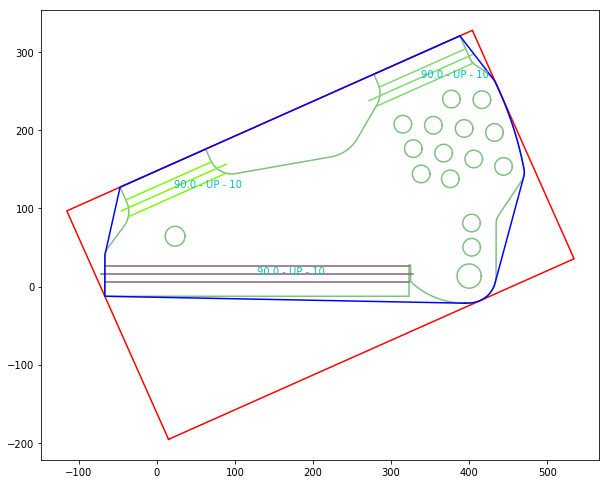

In [14]:
plot_dxf(details)

In [15]:
len(details['closed_patterns'])

17

# Plot a DXF

In [16]:
details.keys()

dict_keys(['thickness', 'unit', 'material', 'radius', 'closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'no_hole_area', 'num_closed_patterns', 'num_open_patterns', 'convex_hull_coords', 'convex_hull_area', 'bend_angle', 'bend_direction', 'bend_line', 'bend_center', 'punch_length', 'bend_radius', 'tangents_coords', 'deformation_length', 'bend_bend_distance', 'bend_bend_angle', 'merged_bend', 'bend_edge_distance', 'bend_edge_angle', 'bend_edge_length'])

In [17]:
details.keys()

dict_keys(['thickness', 'unit', 'material', 'radius', 'closed_patterns', 'open_patterns', 'cut_length', 'total_area', 'minimum_rectangle_coords', 'minimum_rectangle_area', 'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'no_hole_area', 'num_closed_patterns', 'num_open_patterns', 'convex_hull_coords', 'convex_hull_area', 'bend_angle', 'bend_direction', 'bend_line', 'bend_center', 'punch_length', 'bend_radius', 'tangents_coords', 'deformation_length', 'bend_bend_distance', 'bend_bend_angle', 'merged_bend', 'bend_edge_distance', 'bend_edge_angle', 'bend_edge_length'])

# Dataset creation

l1614570_flat1


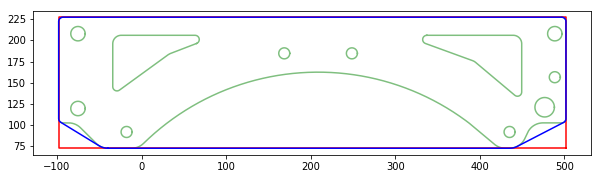

l1616010_flat1


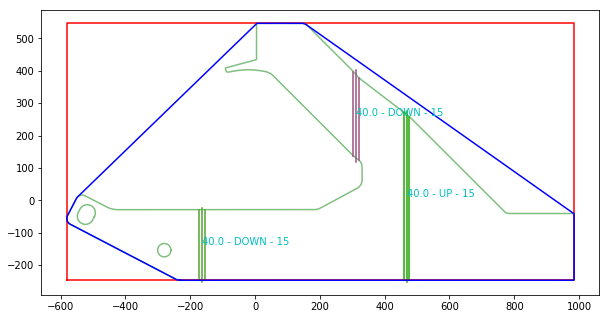

l1616170_flat1


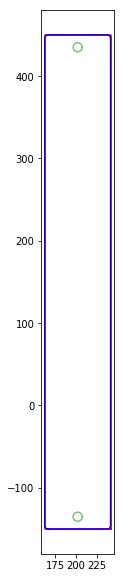

l2500700_flat1


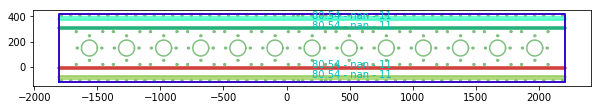

l2503310_flat1


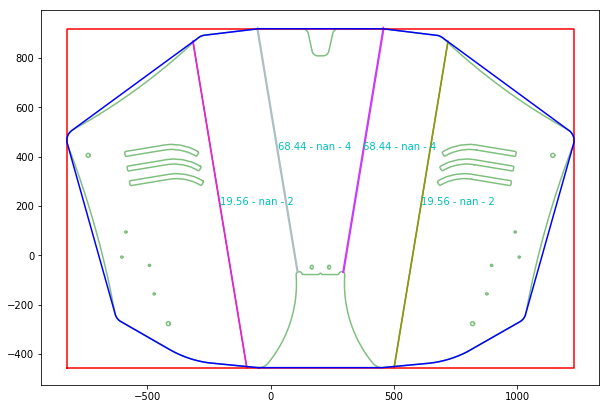

l2507330_flat1


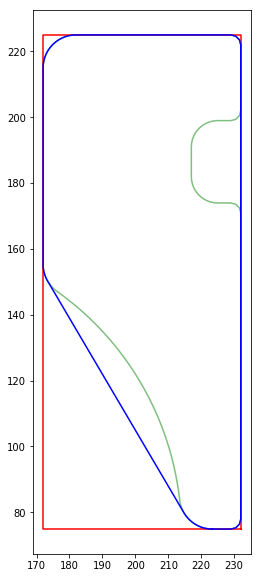

l2510670_flat1


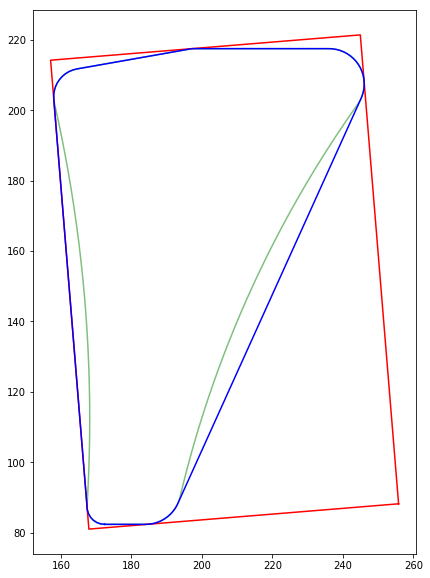

l2512270_flat1


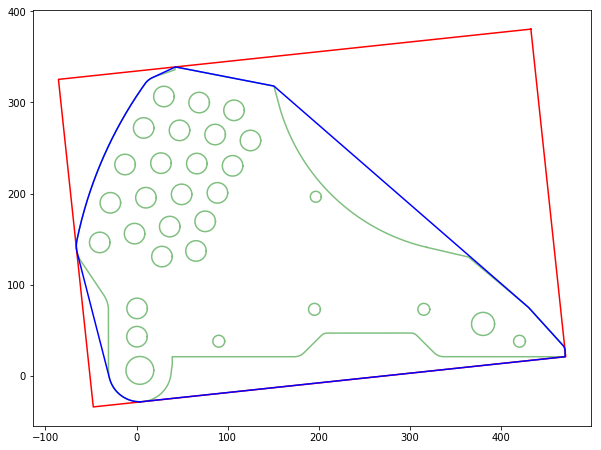

l2512980_flat1


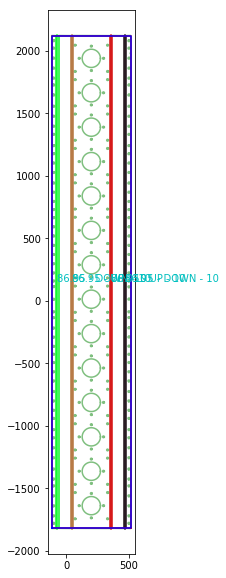

l2518910_flat1


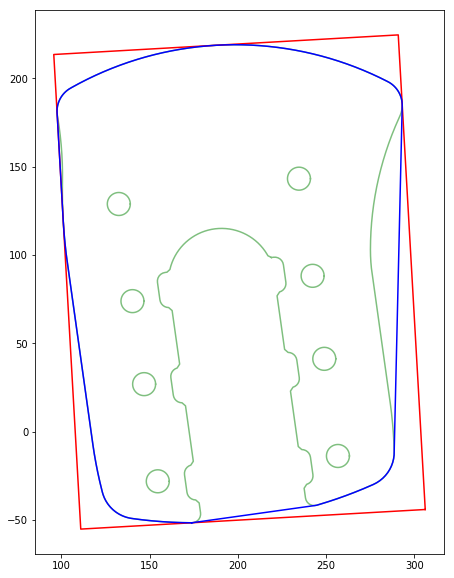

l2522110_flat1


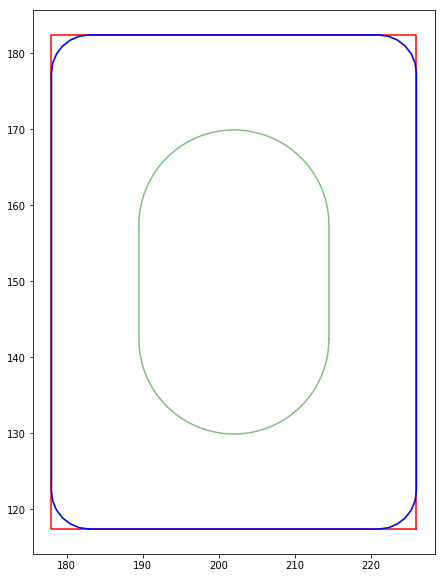

l2603320_flat1


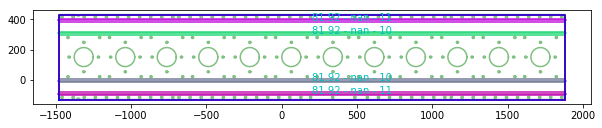

l2606540_flat1


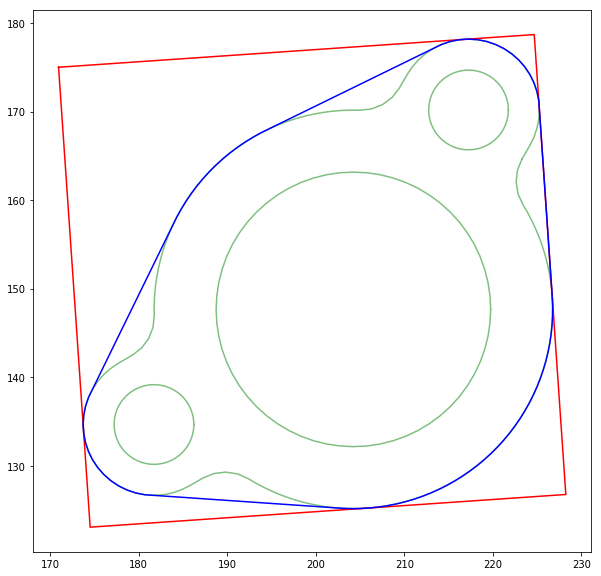

l2607640_flat1


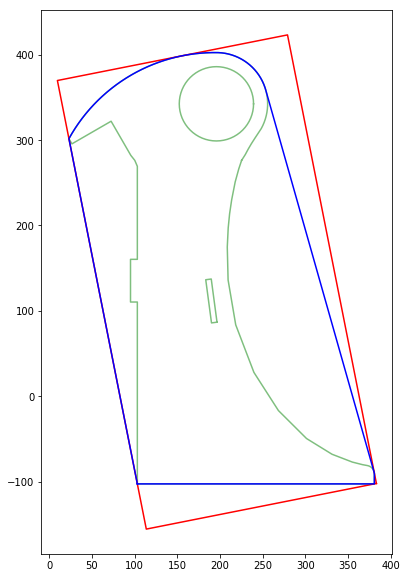

l2607690_flat1


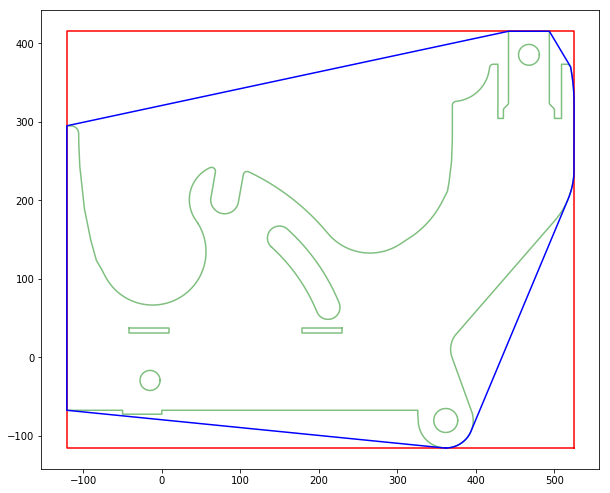

l2608450_flat1


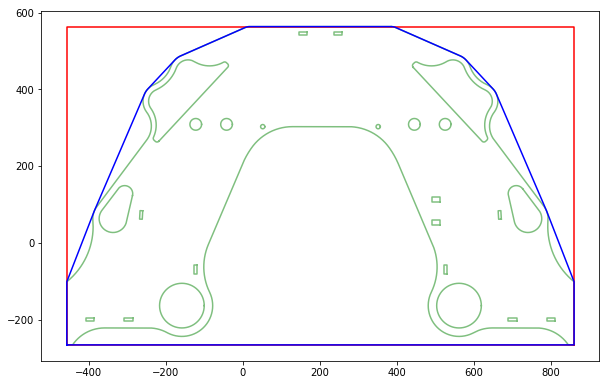

l2609830_flat1


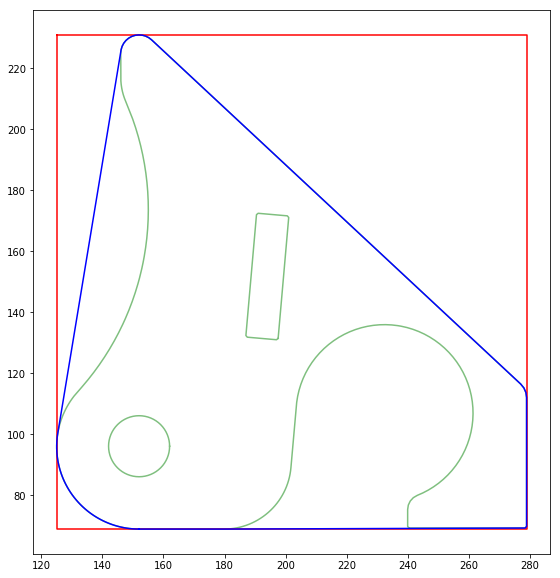

l2701680_flat1


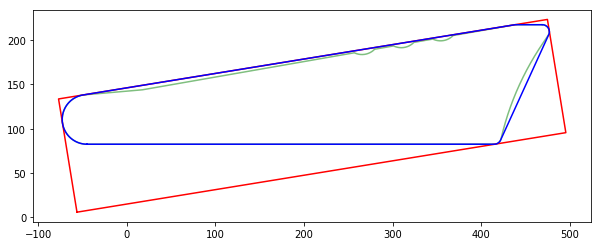

l2703550_flat1


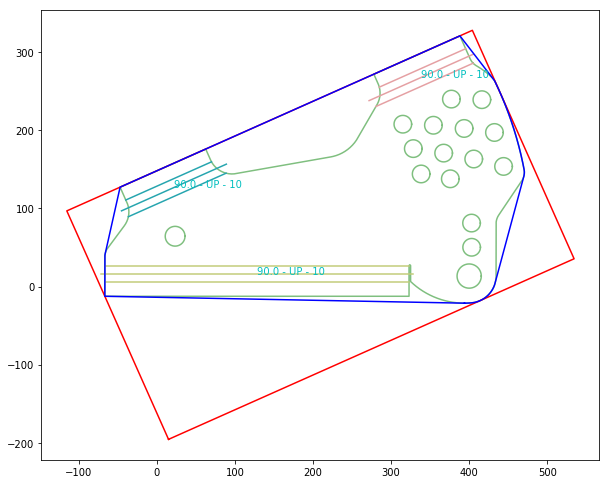

l3006650_flat1


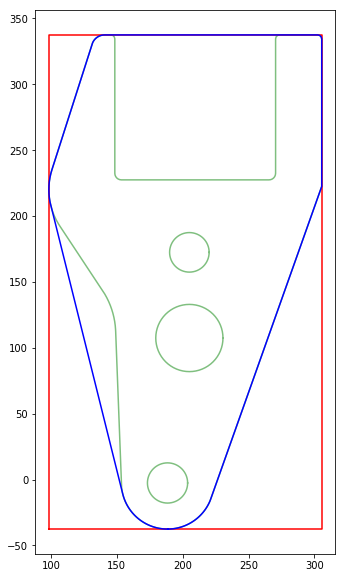

l3007020_flat1


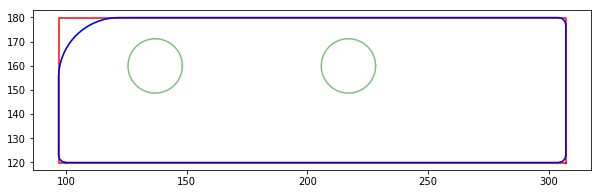

l3009013_flat1


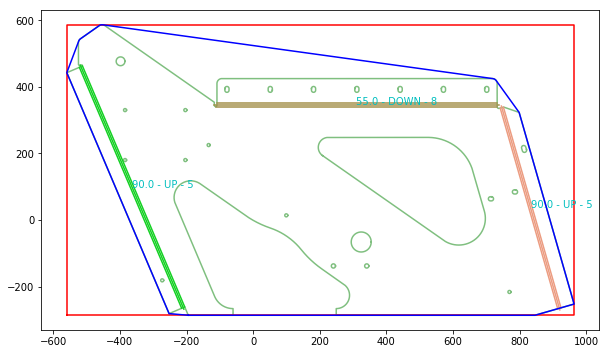

,index,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,...,bend_direction,deformation_length,possible_imperfection,bend_bend_distance,bend_bend_angle,merged_bend,punch_length,bend_edge_distance,bend_edge_angle,bend_edge_length
0,l1614570_flat1,2559.317447,12,0,5.461865e+04,9.300000e+04,600.000000,155.000000,9.114448e+04,6.414829e+04,...,[],[],NaN,[],[],[],[],[],[],[]
1,l1616010_flat1,5147.257835,3,0,4.795804e+05,1.240949e+06,1565.293000,792.790000,7.987351e+05,4.834615e+05,...,"[DOWN, DOWN, UP]","[217.79, 256.78606195155, 511.49063602194997]",NaN,"[[620.1069636814684, 648.5558403345082], [620....","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]","[0, 0, 0]","[227.79, 282.855, 527.918]","[[443.8756752881374, 438.7640187173511, 489.19...","[[135.0, 74.99998270381688, 0.0, 90.0, 135.000...","[[348.95861072912356, 96.46497174104184, 108.4..."
2,l1616170_flat1,1422.117655,3,0,4.779567e+04,4.800000e+04,600.000000,80.000000,4.798544e+04,4.798544e+04,...,[],[],NaN,[],[],[],[],[],[],[]
3,l2500700_flat1,23765.303862,232,0,1.986171e+06,2.180896e+06,4009.000000,544.000000,2.180896e+06,2.180896e+06,...,"[nan, nan, nan, nan]","[4009.0, 4009.0, 4009.0, 4009.0]",NaN,"[[76.30900000000003, 390.27700000000004, 466.5...","[[0.0, 0.0, 0.0], [-0.0, -0.0, 0.0], [0.0, 0.0...","[0, 0, 0, 0]","[4019.0, 4019.0, 4019.0, 4019.0]","[[505.29299999999995, 0.0, 38.706999999999994,...","[[0.0, 90.0, 0.0, 90.0], [0.0, 90.0, 0.0, 90.0...","[[4009.0, 544.0, 4009.0, 544.0], [4009.0, 544...."
4,l2503310_flat1,10668.424952,21,0,2.087388e+06,2.822381e+06,2055.321000,1373.207000,2.269188e+06,2.125233e+06,...,"[nan, nan, nan, nan]","[999.3954440222378, 1330.0878385294293, 999.39...","[((-95.962, -450.535), (-312.771, 863.112)), (...","[[322.14167989139503, 345.6425, 620.6818413603...","[[-3.737747179854978e-05, -161.2564141426033, ...","[0, 0, 0, 0]","[1006.0380646024284, 1341.4176769887893, 1006....","[[434.8111075133661, 607.0438156023006, 0.2224...","[[75.18710267960735, 50.851586492793885, 87.50...","[[135.72656381489955, 226.6178206981966, 217.5..."
5,l2507330_flat1,401.481732,1,0,6.390919e+03,9.000000e+03,150.000000,60.000000,7.195028e+03,6.390919e+03,...,[],[],NaN,[],[],[],[],[],[],[]
6,l2510670_flat1,378.203979,1,0,6.883709e+03,1.177401e+04,133.512414,88.186668,7.707285e+03,6.883709e+03,...,[],[],NaN,[],[],[],[],[],[],[]
7,l2512270_flat1,3526.296578,31,0,8.732622e+04,1.884139e+05,521.312268,361.422403,1.224569e+05,9.833107e+04,...,[],[],NaN,[],[],[],[],[],[],[]
8,l2512980_flat1,25084.417105,233,0,2.231227e+06,2.498242e+06,3947.000000,632.947000,2.498242e+06,2.497997e+06,...,"[DOWN, UP, UP, DOWN]","[3946.7925812612, 3946.7925812612, 3946.792581...","[((201.996, -78.58), (202.704, -78.617)), ((20...","[[115.07400000000001, 428.559, 543.63200000000...","[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","[0, 0, 0, 0]","[3956.792, 3956.792, 3956.792, 3956.792]","[[44.65700000000003, 11.159999999999968, 11.16...","[[0.0, 90.0, 90.0, 90.0, 90.0, 90.0, 0.0, 0.0,...","[[3796.938, 33.49700000000007, 92.752000000000..."
9,l2518910_flat1,1483.423473,9,0,3.363883e+04,5.257082e+04,269.124986,195.339788,4.659951e+04,3.469899e+04,...,[],[],NaN,[],[],[],[],[],[],[]


In [18]:
#List of all the dixs in the folder
dxffolder = os.path.join('/', *os.getcwd().split('/')[:-1], 'Sample')
dxflist = [os.path.join(dxffolder, file) for file in os.listdir(dxffolder) if file.endswith('.dxf')]

columns = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area', 'minimum_rectangle_dim1', 'minimum_rectangle_dim2',
           'convex_hull_area', 'no_hole_area', 'thickness', 'unit', 'material', 'radius', 'bend_radius',
           'bend_angle', 'bend_direction', 'deformation_length', 'possible_imperfection', 'bend_bend_distance',
           'bend_bend_angle', 'merged_bend', 'punch_length',
           'bend_edge_distance', 'bend_edge_angle', 'bend_edge_length']

dataset = pd.DataFrame(columns = columns)
dxfparser = DxfParser(min_edge_length=1, roundigexp=3)
for dxffile in dxflist[:]:
    name = dxffile.split('/')[-1]
    name = name.split('.')[0]
    print(name)
    details = dxfparser.parse(dxffile)
    plot_dxf(details)
    dataset.loc[name] = [details.get(x, np.nan) for x in dataset.columns]
dataset.to_csv('../Sample/Z1 - dataset.csv')
dataset.reset_index()

To add in the dataset:
- DONE + rectangle area
- DONE + rectangle dimension (height and width)
- DONE + Main area (no holes)
- DONE + convex hull area (no holes)
- DONE + Add the forgivness parameter
- bends:
    - DONE + Radius
    - DONE + Placement relative to outside edges (Min length, number, distance)
    - DONE + placement relative to other bends (Distance, Angle)
    - NOT NEEDED + Extend version of the bend lines
    - DONE + Punch length
    - DONE + Angle
    - DONE + Direction
    - DONE + Length of deformation
- DONE + Number of open loops
- DONE + Number of closed loops
- DONE + Cut Length
- DONE + Thickness
- DONE + Material grade